# Starbucks Promotional Offers Data Project (Modelling Notebook)

In [66]:
# Import Python data modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import other functions
from sqlalchemy import create_engine

# Import modelling functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

## Import Data

In [2]:
# Create a connection to the MySQL database
user = 'root'
hidden = 'Basketba11isgood' 
host = 'localhost'
port = '3306'
database = 'starbucks_promotions_db'

connection = create_engine(f'mysql+mysqlconnector://{user}:{hidden}@{host}:{port}/{database}')

In [3]:
# Read in data from the SQL Database
offers = pd.read_sql('SELECT * FROM offers', con=connection)
customers = pd.read_sql('SELECT * FROM customers', con=connection)
transactions = pd.read_sql('SELECT * FROM transactions', con=connection)
offers_received = pd.read_sql('SELECT * FROM offers_received', con=connection)
offers_viewed = pd.read_sql('SELECT * FROM offers_viewed', con=connection)
offers_completed = pd.read_sql('SELECT * FROM offers_completed', con=connection)

In [4]:
customers.head(3)

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,None,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55.0,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,None,NaN,NaN


## Pre-Modelling Preperation & EDA

### Cleaning for Modelling

I will need to deal with the missing values for `income`, `age`, and `gender` columns

In [5]:
# Create a missing values indicator column because it might provide model with more information
customers['missing'] = np.where(customers.isna().any(axis=1), 1, 0)

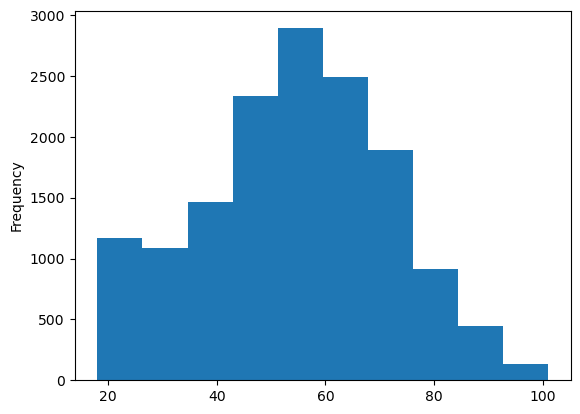

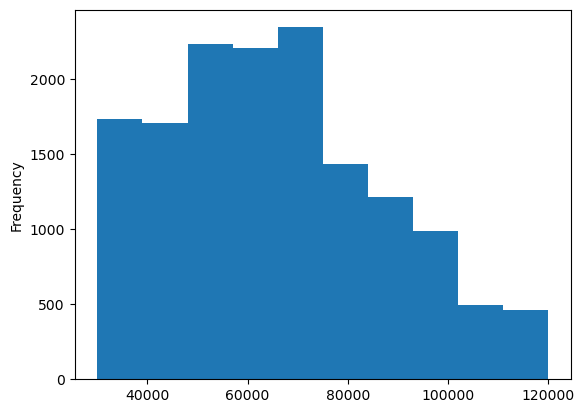

In [6]:
# Check the distributions of the income and gender columns to see if there is any skew
for column in ['age', 'income']:
    customers[column].plot.hist()
    plt.show()

There is some skew in both of these distributions. Therefore, I will impute the missing values in these columns with the median.

In [7]:
# Fill in the missing values with the median for the age and income columns
for column in ['age', 'income']:
    customers[column] = customers[column].fillna(customers[column].median())

In [8]:
# Check the distribution of gender values
customers['gender'].value_counts(normalize=True, dropna=False)

gender
M       0.499059
F       0.360529
None    0.127941
O       0.012471
Name: proportion, dtype: float64

In [9]:
# Add a 'Missing' value for None values
customers['gender'] = customers['gender'].fillna('Missing')

### Defining a Target

In [10]:
# Create a DataFrame that says how many times each customer completed an offer sent to them
num_completed = (offers_completed.groupby('customer_id')[['offer_id']]
                                 .count()
                                 .rename({'offer_id': 'num_completed'}, axis=1)
                                 .reset_index()
                )

# Add the num_completed column to the customers table by merging the two DataFrames
customers = customers.merge(num_completed, how='left', on='customer_id')

# Change the num_completed column to be binary (1 if customer completed an offer, 0 if not)
customers['num_completed'] = np.where(customers['num_completed'] > 0, 1, 0)

# Rename the column to represent this change
customers = customers.rename({'num_completed': 'completed'}, axis=1)

In [11]:
# Check the target (completed column) distribution to see if there are any imbalances
customers['completed'].value_counts(normalize=True)

completed
1    0.751412
0    0.248588
Name: proportion, dtype: float64

The target is unbalanced. May need to use balancing methods

### Exploring the Features

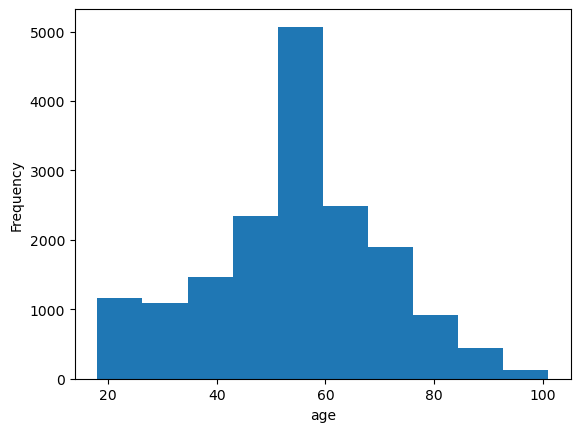

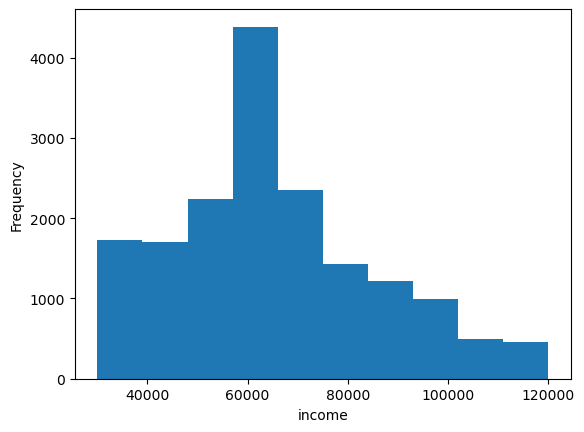

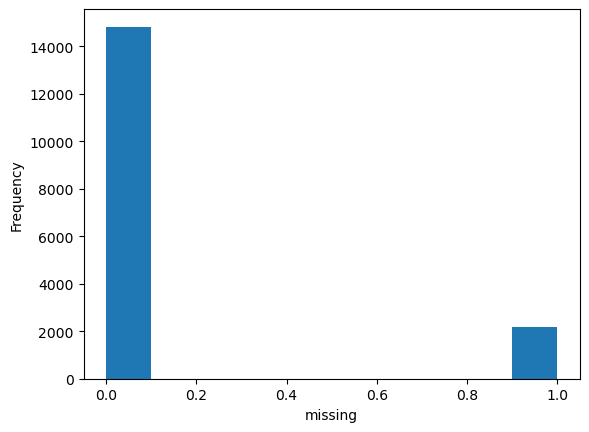

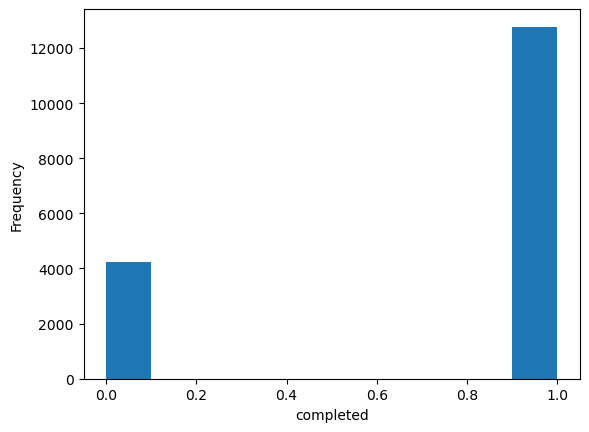

In [12]:
# See the distribution of each numeric feature by plotting histograms
for column in customers.select_dtypes(include='number'):
    customers[column].plot.hist()
    plt.xlabel(column)
    plt.show()

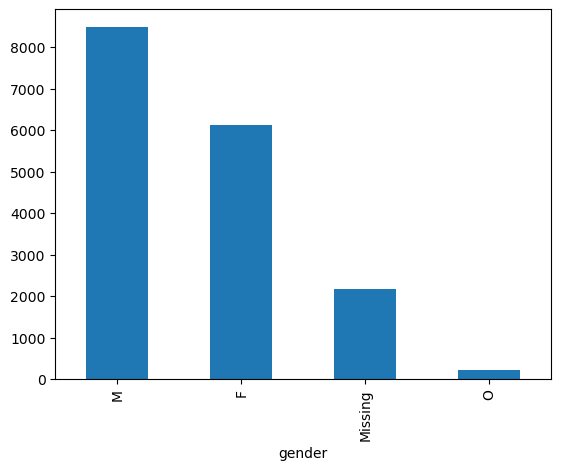

In [13]:
# See the distribution of each categorical feature by plotting bar charts
customers['gender'].value_counts().plot.bar()
plt.show()

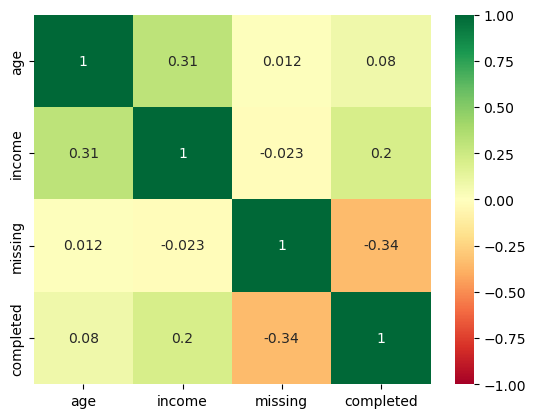

In [14]:
# Explore the correlation of the numeric variables
sns.heatmap(
    customers.corr(numeric_only=True), 
    vmin=-1,
    vmax=1,
    annot=True,
    cmap='RdYlGn'
);

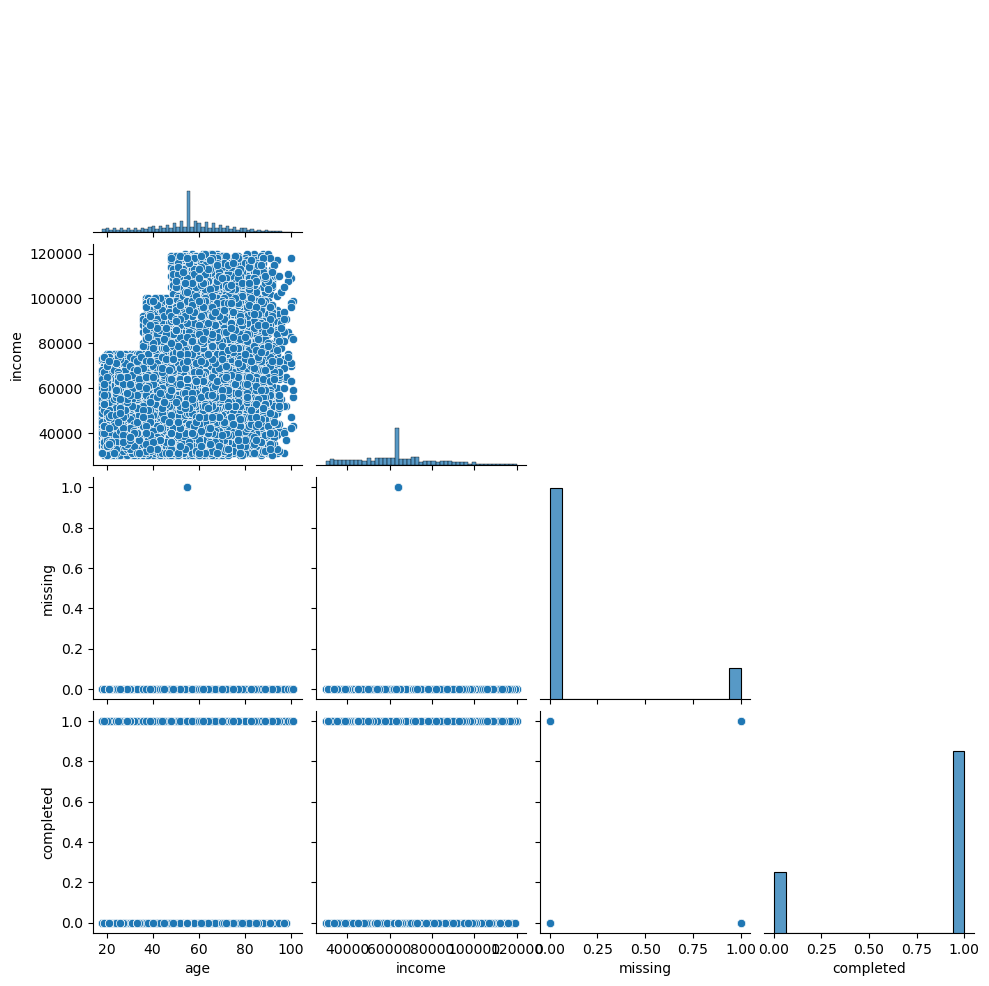

In [15]:
# Look at the relationships between the numeric variables
sns.pairplot(customers, corner=True);

### Explore Feature-Target Relationships

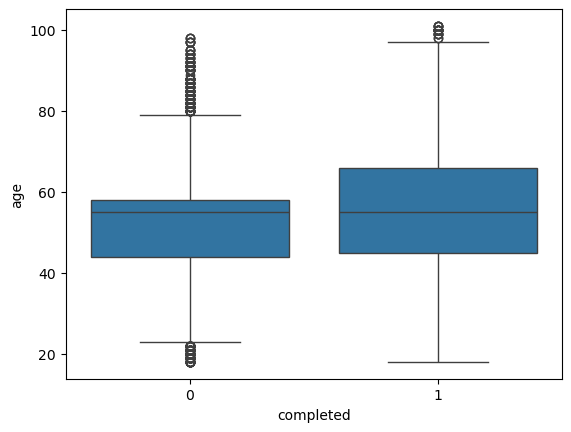

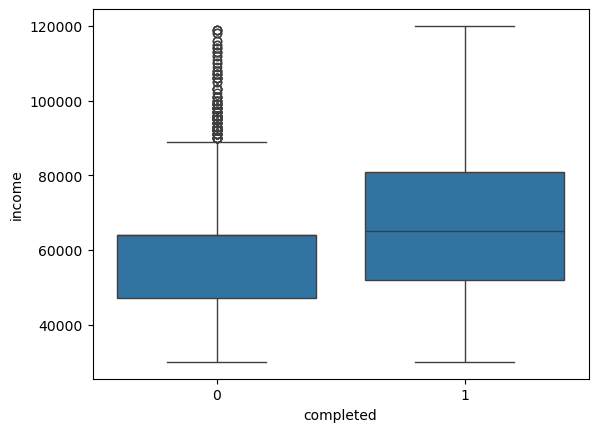

In [16]:
for column in customers.select_dtypes(include='number').drop(['completed', 'missing'], axis=1):
    sns.boxplot(customers, x='completed', y=column)
    plt.show()

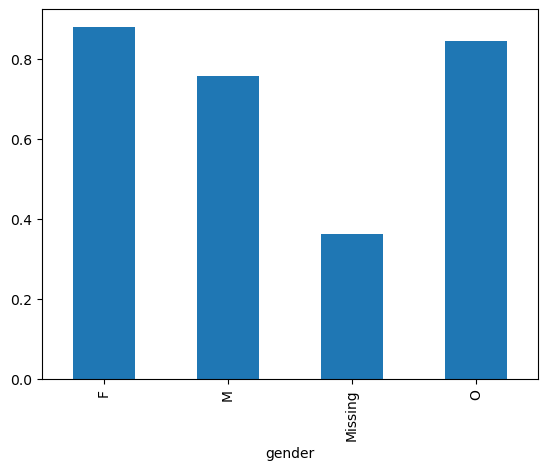

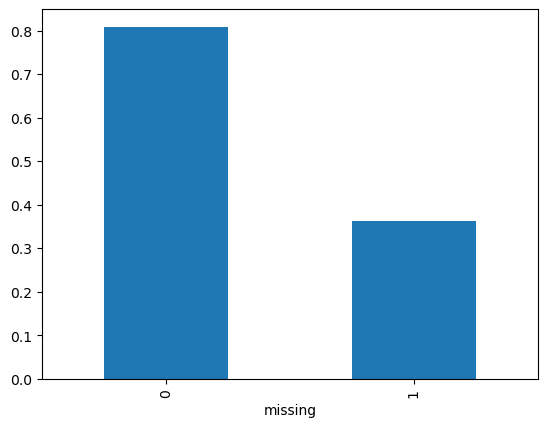

In [17]:
for column in customers[['gender', 'missing']]:
    customers.groupby(column)['completed'].mean().plot.bar()
    plt.show()

### Modelling Preperation

In [18]:
# Create a copy of the customers DataFrame so we can easily go back and look at the base customers table if needed
model = customers.copy()

In [19]:
# Drop the customer identifier column and the missing column since the dummy variable for the 'Missing' gender category will be the same
model = model.drop(['customer_id', 'missing'], axis=1)

In [25]:
# Turn the categorical variables (just gender in this case) into dummy variables
model = pd.get_dummies(
    model.assign(
        # Bin the became_member_on column by extracting just the year
        became_member_on = model['became_member_on'].dt.year
    ),
    drop_first=True,
    dtype='int'
)

In [27]:
# Check the modelling DataFrame
model.head()

,became_member_on,age,income,completed,gender_M,gender_Missing,gender_O
0,2017,55.0,64000.0,1,0,1,0
1,2017,55.0,112000.0,1,0,0,0
2,2018,55.0,64000.0,0,0,1,0
3,2017,75.0,100000.0,1,0,0,0
4,2017,55.0,64000.0,0,0,1,0


In [59]:
# Chose the features and define the target varaible
X = model[[
        'became_member_on',
        'age',
        'income',
        'gender_M',
        'gender_Missing',
        'gender_O'
]]
y = model['completed']

# Split the data into a train and test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, 
    y, 
    test_size=0.15,
    random_state=42, 
    stratify=y
)

# Split the train data into a train and validation set
X_train, X_val, y_train, y_val  = train_test_split(
    X_temp, 
    y_temp, 
    test_size=15/85,
    random_state=42, 
    stratify=y_temp
)

In [62]:
# Create standardised datasets if needed for particular models
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_val_std = std.fit_transform(X_val)
X_test_std = std.fit_transform(X_test)

## Modelling

In [69]:
def scoring(model, X, y):
    """
    
    """
    sns.heatmap(
        confusion_matrix(y, model.predict(X)),
        cmap='Blues',
        annot=True,
        fmt='g',
        square=True,
        xticklabels=['None Completed', 'Completed'],
        yticklabels=['None Completed', 'Completed'],
    ).set(
        xlabel='Actual',
        ylabel='Predicted',
        title='Confusion_Matrix'
    );
    print(f'')
    

### K-Nearest Neighbours Model

In [65]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_std, y_train)

KNeighborsClassifier()

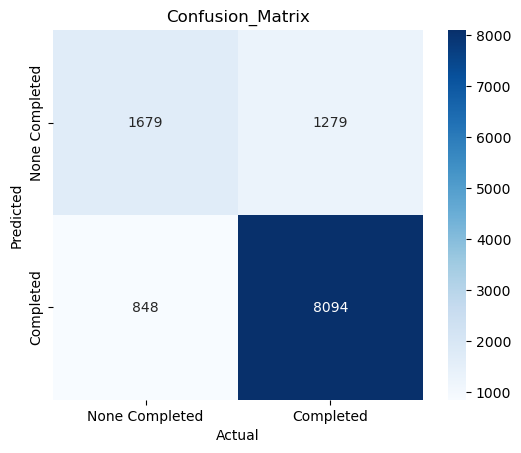

In [71]:
scoring(knn, X_train_std, y_train)